**Problem Statement:**

Weather conditions significantly impact various aspects of daily life, from agriculture to transportation. Accurate and timely classification of weather conditions using images can enhance weather forecasting and monitoring capabilities. However, manual classification is time-consuming and subject to human error. The challenge lies in developing an automated, efficient, and accurate system for classifying weather conditions from images.

**Objective:**

Develop a deep learning model that can accurately classify images into distinct weather categories like cloudy, rain, shine and sunrise. Implement robust data preprocessing and augmentation strategies to standardize and diversify the dataset, enhancing the model's accuracy and ability to reliably recognize various weather conditions.

Link to dataset: https://data.mendeley.com/datasets/4drtyfjtfy/1

**Importing Libraries**

In [65]:
import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Concatenate, BatchNormalization,Activation
from tensorflow.keras.callbacks import EarlyStopping

**Extracting File**

In [2]:
zip_file_path = 'dataset2.zip'  # Replace with the path to your ZIP file
extraction_path = ''  # Replace with your desired extraction path

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the directory
    zip_ref.extractall(extraction_path)


**Creating DataFrame**

In [3]:
dataset_dir = 'dataset2'
data = []
for filename in os.listdir(dataset_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        label = ''.join([char for char in filename if not char.isdigit()]).split('.')[0]
        file_path = os.path.join(dataset_dir, filename)
        data.append([file_path, label])

# Create a DataFrame
df = pd.DataFrame(data, columns=['filename', 'label'])
df.head()

,filename,label
0,dataset2\cloudy1.jpg,cloudy
1,dataset2\cloudy10.jpg,cloudy
2,dataset2\cloudy100.jpg,cloudy
3,dataset2\cloudy101.jpg,cloudy
4,dataset2\cloudy102.jpg,cloudy


**Class distribution**

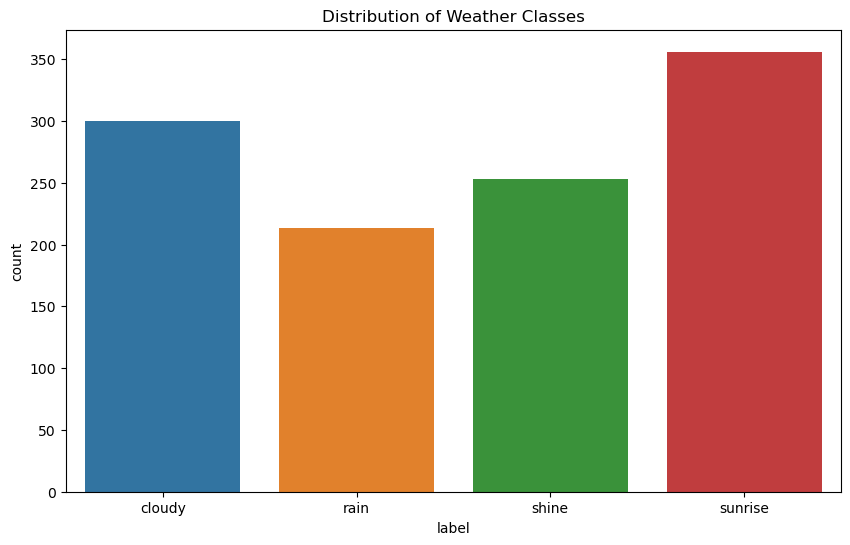

In [4]:
# Plot label distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Weather Classes')
plt.show()

**Visualizing Images**

In [5]:
def plot_images(img_paths):
    num_images = len(img_paths)
    plt.figure(figsize=(12, num_images * 3))  # Adjusting figure size

    for i, path in enumerate(img_paths):
        img = Image.open(path)
        img_array = np.array(img)

        # Create a subplot for each image
        plt.subplot(num_images, 1, i + 1)  # Adjusting for subplot indexing
        plt.imshow(img)
        plt.axis('off')
        
        # Extracting title from the file path and setting it
        title = ''.join([char for char in path if not char.isdigit()]).split('/')[-1].split('.')[0]
        plt.title(f"{title}\nShape: {img_array.shape}")

    plt.tight_layout()
    plt.show()


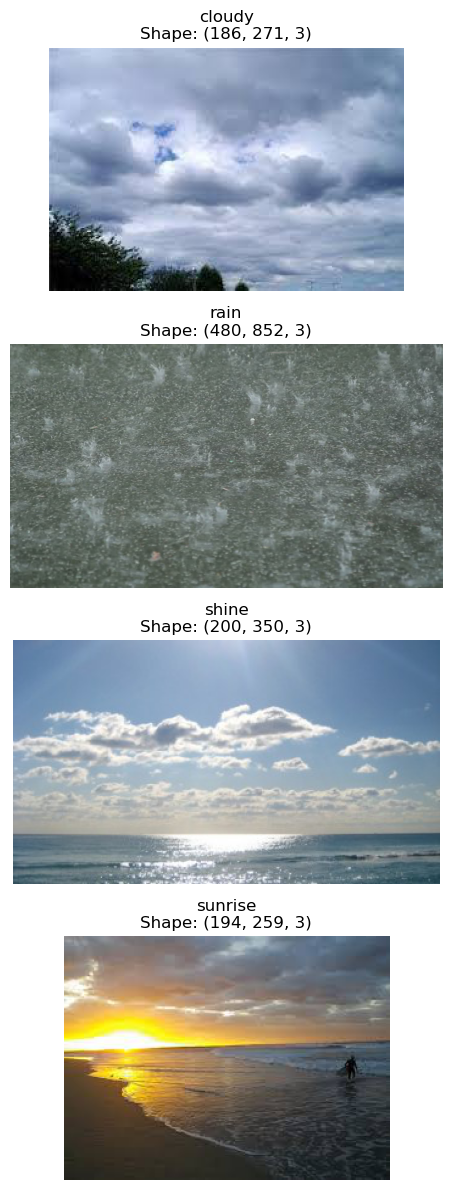

In [6]:
plot_images(['dataset2/cloudy10.jpg','dataset2/rain46.jpg','dataset2/shine58.jpg','dataset2/sunrise26.jpg'])

It appears that while all images in your dataset are in RGB format, they vary in size.

**Splitting into Train, Valid and Test data**

In [7]:
train, val_test = train_test_split(df, test_size=0.1, random_state=42, stratify=df['label'])
val, test = train_test_split(val_test, test_size=0.5, random_state=42, stratify=val_test['label'])  

In [8]:
# checking class distribution of train data
train['label'].value_counts()

label
sunrise    320
cloudy     270
shine      227
rain       192
Name: count, dtype: int64

Looks like our data is somewhat imbalanced. Let's deal with that by using class weights to give more importance to underrepresented classes during training


**Create Image DataGenerators**

In [9]:
# train data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

# valid,test data
test_datagen = ImageDataGenerator(
    rescale = 1./255
)



**Create Generators for Train, Validation, and Test Sets**

In [10]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='filename',
    y_col='label',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)


Found 1009 validated image filenames belonging to 4 classes.


In [11]:
validation_generator = test_datagen.flow_from_dataframe(
    dataframe=val,
    x_col='filename',
    y_col='label',
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)


Found 56 validated image filenames belonging to 4 classes.


In [12]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='filename',
    y_col='label',
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)


Found 57 validated image filenames belonging to 4 classes.


**Class weights**

In [13]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train['label']),
    y=train['label']
)
class_weight_dict = dict(enumerate(class_weights))

**Helper functions**

In [14]:
def compile_model(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


In [15]:
def create_early_stopping(monitor='val_loss', patience=5, restore_best_weights=True):
    early_stopping = EarlyStopping(
        monitor=monitor,
        patience=patience,
        restore_best_weights=restore_best_weights
    )
    return early_stopping


In [16]:
def train_model(model, epochs,callbacks=None):
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=callbacks
    )
    return history


In [17]:
def evaluate_model(model):
    test_loss, test_accuracy=model.evaluate(test_generator)
    return f"Test Accuracy: {test_accuracy}"


In [18]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


In [19]:
def predict_and_confusion_matrix(model, test_generator):
    # Generate predictions
    predictions = model.predict(test_generator)

    # Convert predictions to class labels
    predicted_classes = np.argmax(predictions, axis=1)

    # Retrieve true class labels
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # Create a DataFrame for comparison
    pred_df = pd.DataFrame({'True Label': true_classes, 'Predicted Label': predicted_classes})
    pred_df['True Label'] = pred_df['True Label'].map(lambda x: class_labels[x])
    pred_df['Predicted Label'] = pred_df['Predicted Label'].map(lambda x: class_labels[x])

    # Build confusion matrix
    cm = confusion_matrix(pred_df['True Label'], pred_df['Predicted Label'], labels=class_labels)
    
    # Plotting confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return pred_df


**1st Architecture - Single CNN**

In [20]:
# Define your input shape and number of classes
input_shape = (224,224, 3) 
num_classes = 4 

In [21]:
def basic_cnn(input_shape, num_classes):
    model = Sequential([
        # 1st Convolutional layer
        Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=input_shape),
        MaxPooling2D(2, 2),
        # Flatten and Fully Connected Layers
        Flatten(),
        Dense(256, activation='relu'),
        # Dropout for regularization
        Dropout(0.5),
        #Output layer
        Dense(num_classes, activation='softmax')
    ])
    return model


In [22]:
# Create the CNN model
model1 = basic_cnn(input_shape, num_classes)

# print model summary
model1.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 401408)            0         
                                                                 
 dense (Dense)               (None, 256)               102760704 
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                      

In [23]:
# Compile the model
compile_model(model1)

# Create Early Stopping callback
early_stopping = create_early_stopping()

# Train the model
history1 = train_model(model1, epochs=50,callbacks=[early_stopping])


Epoch 1/50


32/32 [==============================] - 64s 2s/step - loss: 18.6888 - accuracy: 0.5144 - val_loss: 0.9059 - val_accuracy: 0.7857
Epoch 2/50
32/32 [==============================] - 59s 2s/step - loss: 0.9322 - accuracy: 0.6878 - val_loss: 0.6364 - val_accuracy: 0.7857
Epoch 3/50
32/32 [==============================] - 62s 2s/step - loss: 0.7002 - accuracy: 0.7483 - val_loss: 0.4971 - val_accuracy: 0.8750
Epoch 4/50
32/32 [==============================] - 65s 2s/step - loss: 0.6561 - accuracy: 0.7473 - val_loss: 0.4791 - val_accuracy: 0.8750
Epoch 5/50
32/32 [==============================] - 61s 2s/step - loss: 0.5947 - accuracy: 0.7730 - val_loss: 0.4091 - val_accuracy: 0.8929
Epoch 6/50
32/32 [==============================] - 65s 2s/step - loss: 0.6074 - accuracy: 0.7899 - val_loss: 0.3703 - val_accuracy: 0.9107
Epoch 7/50
32/32 [==============================] - 70s 2s/step - loss: 0.5088 - accuracy: 0.8137 - val_loss: 0.3854 - val_accuracy: 0.9107
Epoch 8/50
32/32

In [24]:
# evaluate model
evaluate_model(model1)

4/4 [==============================] - 1s 168ms/step - loss: 0.4362 - accuracy: 0.8246


'Test Accuracy: 0.8245614171028137'

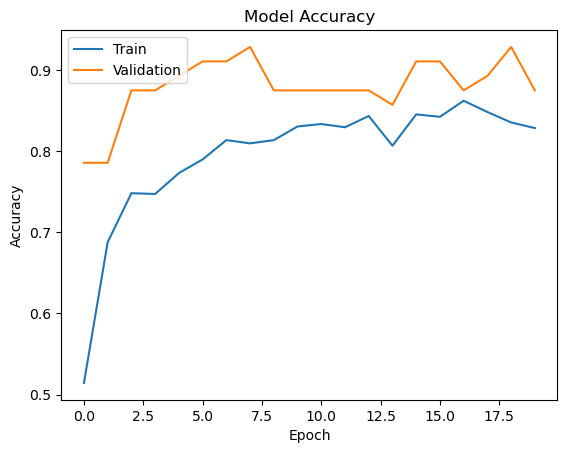

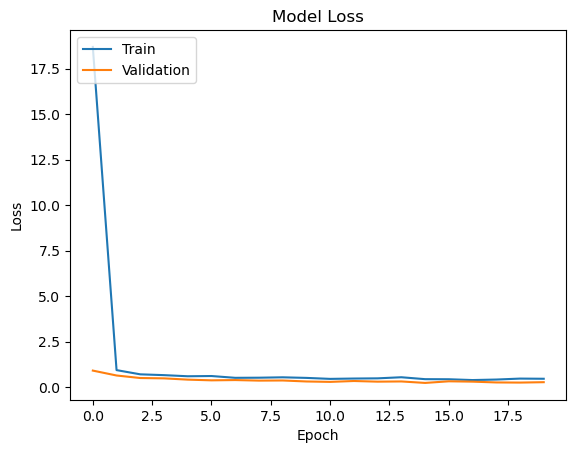

In [25]:
# Plot the training history
plot_training_history(history1)

4/4 [==============================] - 1s 153ms/step


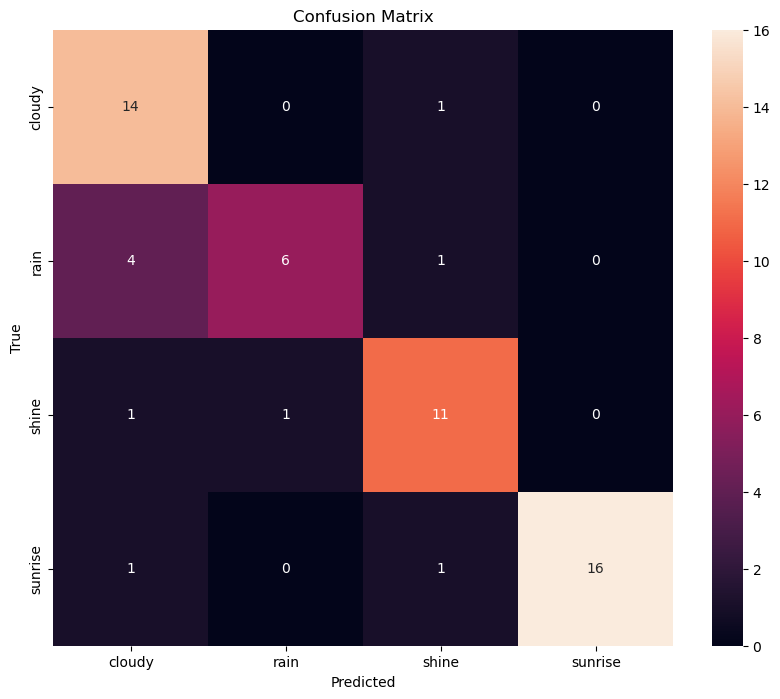

In [26]:
# look at predictions and confusion matrix
pred1 = predict_and_confusion_matrix(model1,test_generator)

**2nd Architecture - Multi Layered CNN's**

In [27]:
def multilayer_cnn(input_shape, num_classes):
    model = Sequential([
        # 1st Convolutional Layer
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D(2, 2),
        # 2nd Convolutional Layer
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        # 3rd Convolutional Layer
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        # Flatten and Fully Connected Layers
        Flatten(),
        Dense(128, activation='relu'),
        # Dropout for regularization
        Dropout(0.50),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [28]:
# Create the CNN model
model2 = multilayer_cnn(input_shape, num_classes)

# print model summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 28, 28, 128)      

In [29]:
# Compile the model
compile_model(model2)

# Create Early Stopping callback
early_stopping = create_early_stopping()

# Train the model
history2 = train_model(model2, epochs=50,callbacks=[early_stopping])

Epoch 1/50
32/32 [==============================] - 70s 2s/step - loss: 1.2018 - accuracy: 0.5897 - val_loss: 0.5852 - val_accuracy: 0.8571
Epoch 2/50
32/32 [==============================] - 56s 2s/step - loss: 0.6628 - accuracy: 0.7463 - val_loss: 0.3990 - val_accuracy: 0.8571
Epoch 3/50
32/32 [==============================] - 57s 2s/step - loss: 0.5728 - accuracy: 0.7810 - val_loss: 0.4629 - val_accuracy: 0.8929
Epoch 4/50
32/32 [==============================] - 43s 1s/step - loss: 0.4991 - accuracy: 0.8276 - val_loss: 0.3319 - val_accuracy: 0.8571
Epoch 5/50
32/32 [==============================] - 39s 1s/step - loss: 0.4923 - accuracy: 0.8305 - val_loss: 0.2532 - val_accuracy: 0.8750
Epoch 6/50
32/32 [==============================] - 39s 1s/step - loss: 0.3776 - accuracy: 0.8702 - val_loss: 0.1529 - val_accuracy: 0.9643
Epoch 7/50
32/32 [==============================] - 51s 2s/step - loss: 0.4560 - accuracy: 0.8414 - val_loss: 0.2582 - val_accuracy: 0.8750
Epoch 8/50
32/32 [==

In [30]:
# evaluate model
evaluate_model(model2)

4/4 [==============================] - 1s 259ms/step - loss: 0.3358 - accuracy: 0.9298


'Test Accuracy: 0.9298245906829834'

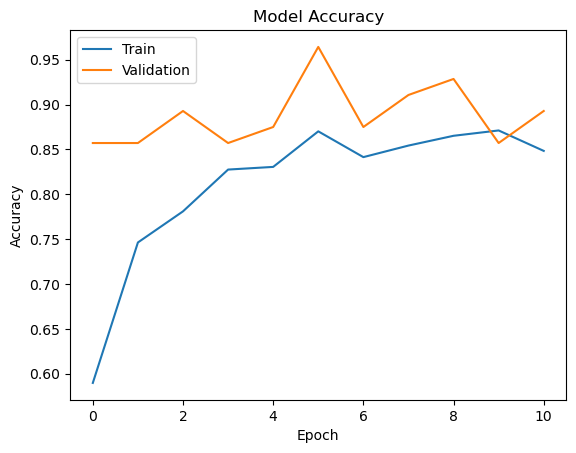

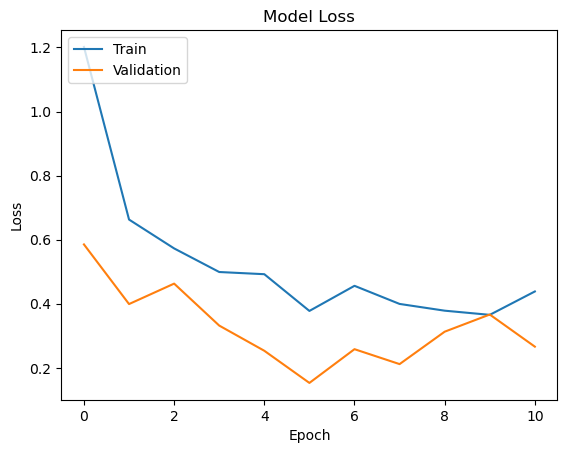

In [31]:
# Plot the training history
plot_training_history(history2)

4/4 [==============================] - 1s 188ms/step


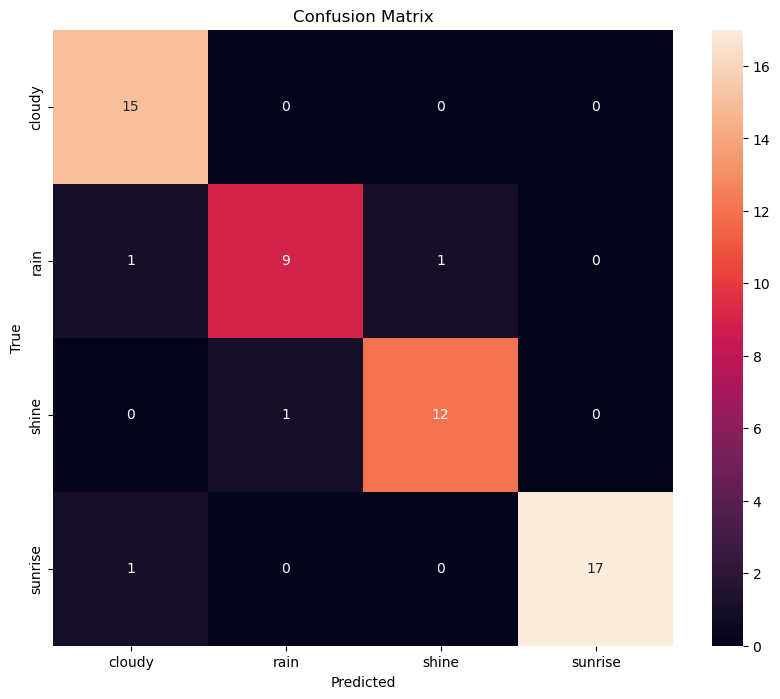

In [32]:
# look at predictions and confusion matrix
pred2 = predict_and_confusion_matrix(model2,test_generator)

**3rd architecture Using Merge Layers**

In [71]:
def cnn_with_merge(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Convolutional layer
    conv1 = Conv2D(32, (3, 3), activation='relu',padding='same')(inputs)
    conv1 = MaxPooling2D(2, 2)(conv1)

    # Convolutional layer
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv2 = MaxPooling2D(2, 2)(conv2)

    # Merge paths
    merged = Concatenate()([conv1,conv2])
    
    # Convolutional layer
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(merged)
    conv3 = MaxPooling2D(2, 2)(conv3)
    
    # Convolutional layer
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(merged)
    conv4 = MaxPooling2D(2, 2)(conv4)
    
    # Merge paths
    merged = Concatenate()([conv3,conv4])
    
    # Convolutional layer
    conv5 = Conv2D(64, (3, 3), activation='relu')(merged)
    conv5 = MaxPooling2D(2, 2)(conv5)

    # Additional layers after merging
    merged = Flatten()(conv5)
    merged = Dense(256, activation='relu')(merged)
    drop = Dropout(0.25)(merged)
    merged = Dense(128, activation='relu')(drop)
    output = Dense(num_classes, activation='softmax')(merged)

    model = Model(inputs=inputs, outputs=output)
    return model

In [72]:
# Create the CNN model
model3 = cnn_with_merge(input_shape, num_classes)

# print model summary
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_17 (Conv2D)          (None, 224, 224, 32)         896       ['input_5[0][0]']             
                                                                                                  
 conv2d_18 (Conv2D)          (None, 224, 224, 32)         896       ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_15 (MaxPooli  (None, 112, 112, 32)         0         ['conv2d_17[0][0]']           
 ng2D)                                                                                      

In [73]:
# Compile the model
compile_model(model3)

# Create Early Stopping callback
early_stopping = create_early_stopping()

# Train the model
history3 = train_model(model3, epochs=50,callbacks=[early_stopping])

Epoch 1/50
32/32 [==============================] - 56s 2s/step - loss: 1.0026 - accuracy: 0.5818 - val_loss: 0.7621 - val_accuracy: 0.6786
Epoch 2/50
32/32 [==============================] - 53s 2s/step - loss: 0.6706 - accuracy: 0.7175 - val_loss: 0.4787 - val_accuracy: 0.8214
Epoch 3/50
32/32 [==============================] - 65s 2s/step - loss: 0.5539 - accuracy: 0.7750 - val_loss: 0.3880 - val_accuracy: 0.8750
Epoch 4/50
32/32 [==============================] - 74s 2s/step - loss: 0.4970 - accuracy: 0.7968 - val_loss: 0.3144 - val_accuracy: 0.8929
Epoch 5/50
32/32 [==============================] - 70s 2s/step - loss: 0.4994 - accuracy: 0.8048 - val_loss: 0.4011 - val_accuracy: 0.8929
Epoch 6/50
32/32 [==============================] - 66s 2s/step - loss: 0.5199 - accuracy: 0.7909 - val_loss: 0.4234 - val_accuracy: 0.8036
Epoch 7/50
32/32 [==============================] - 65s 2s/step - loss: 0.4736 - accuracy: 0.8216 - val_loss: 0.4141 - val_accuracy: 0.8393
Epoch 8/50
32/32 [==

In [74]:
# evaluate model
evaluate_model(model3)

4/4 [==============================] - 1s 255ms/step - loss: 0.4468 - accuracy: 0.8772


'Test Accuracy: 0.8771929740905762'

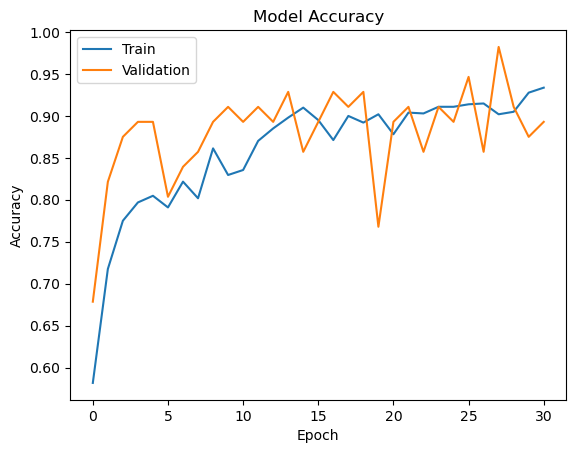

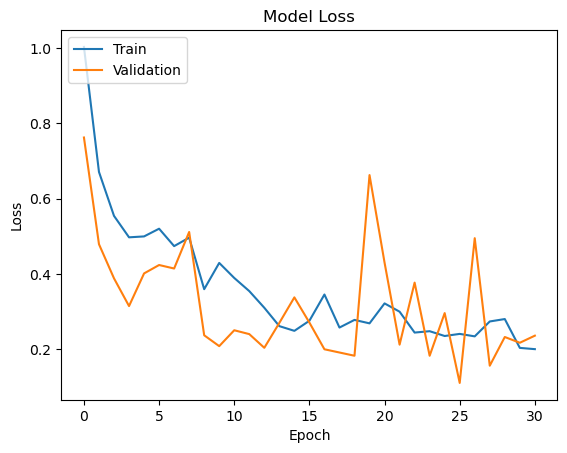

In [75]:
# Plot the training history
plot_training_history(history3)

4/4 [==============================] - 2s 241ms/step


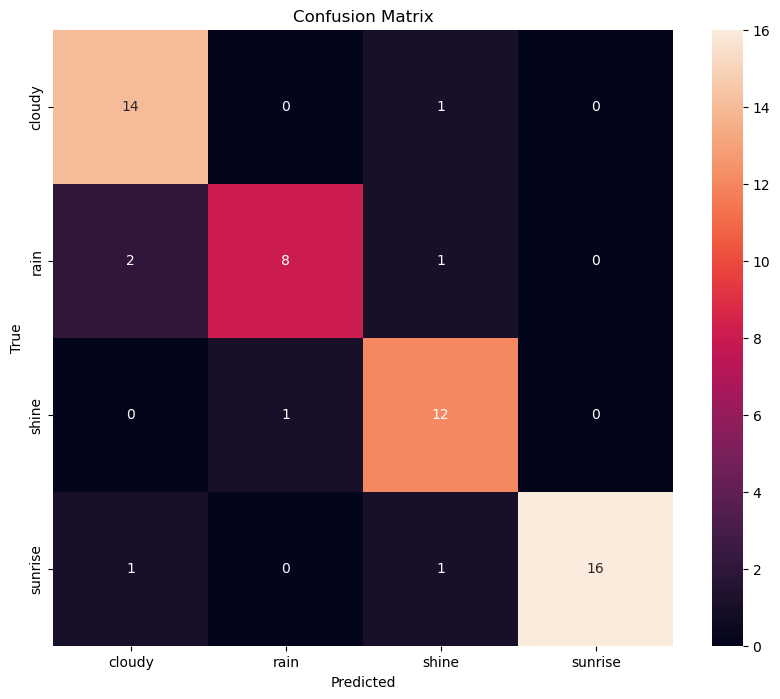

In [76]:
# look at predictions and confusion matrix
pred3 = predict_and_confusion_matrix(model3,test_generator)